In [1]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.8.10
pandas==1.5.1
numpy==1.23.4
sklearn==1.1.3
torch==1.13.0+cu117
matplotlib==3.6.2


In [3]:
#load data
data = pd.read_csv("E:\GitHub\MasterWork\Data\Day\S&P 500 Historical Data00-20.csv")

In [4]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [5]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [6]:
data.index = data.index[::-1]

In [7]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [8]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [9]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [10]:
#change indexes
special_data.set_index('Date', inplace=True)

In [11]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [12]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


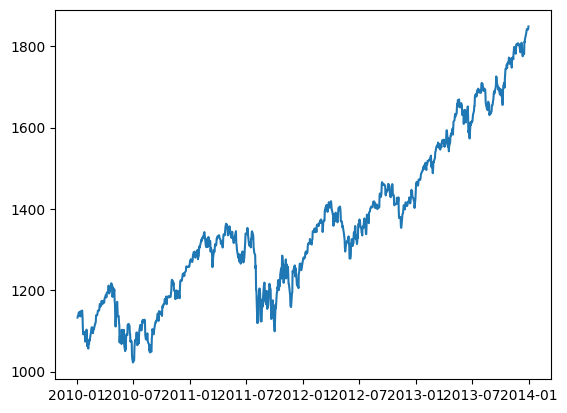

In [13]:
plt.plot(special_data)

In [22]:
train_len = int(len(special_data) * 0.7)
train = special_data[:train_len]
test = special_data[train_len - len(special_data):]
test_len = len(test)

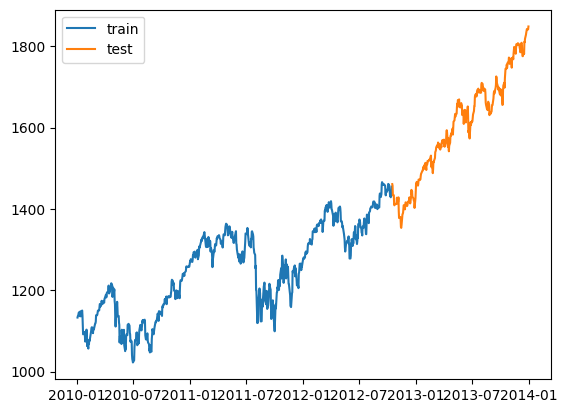

In [23]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.legend()
plt.show()

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)

In [25]:
train_scaled = torch.FloatTensor(train_scaled)
print(f'Original dimensions : {train_scaled.shape}')
train_scaled = train_scaled.view(-1)
print(f'Correct dimensions : {train_scaled.shape}')

Original dimensions : torch.Size([704, 1])
Correct dimensions : torch.Size([704])


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [26]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    
    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)
    
    return x_train, y_train

train_periods = 16 #-- number of quarters for input
prediction_periods = test_len
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)

torch.Size([386, 16])
torch.Size([386, 302])


In [35]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    """
    input_size - will be 1 in this example since we have only 1 predictor (a sequence of previous values)
    hidden_size - Can be chosen to dictate how much hidden "long term memory" the network will have
    output_size - This will be equal to the prediciton_periods input to get_x_y_pairs
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size).to(device),
                           torch.zeros(1,1,self.hidden_size).to(device))
        else:
            self.hidden = hidden
            
        """
        inputs need to be in the right shape as defined in documentation
        - https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        
        lstm_out - will contain the hidden states from all times in the sequence
        self.hidden - will contain the current hidden state and cell state
        """
        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1), 
                                          self.hidden)
        
        predictions = self.linear(lstm_out.view(len(x), -1))
        
        return predictions[-1], self.hidden

In [36]:
model = LSTM(input_size = 1, hidden_size = 50, output_size = test_len)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [47]:
epochs = 600
model.train()
loss_data = []
x_train = x_train.to(device)
y_train = y_train.to(device)
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    loss_data.append(loss.item())
    if epoch%100==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

epoch:    0 loss:0.01558347
epoch:  100 loss:0.01881247
epoch:  200 loss:0.01769090
epoch:  300 loss:0.01249344
epoch:  400 loss:0.02455798
epoch:  500 loss:0.01979009
epoch:  600 loss:0.01676600


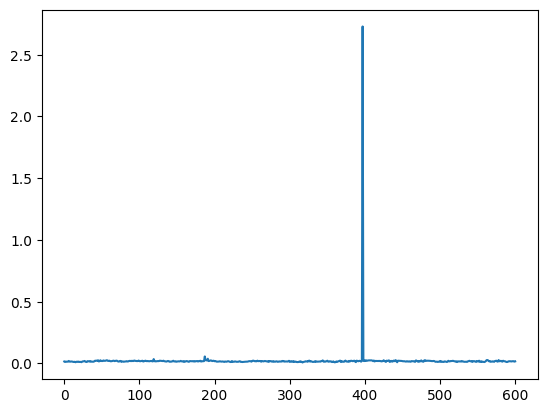

In [49]:
plt.plot(loss_data)

In [40]:
model.eval()
with torch.no_grad():
    predictions, _ = model(train_scaled[-train_periods:].to(device), None)

In [43]:

#-- Apply inverse transform to undo scaling
predictions = scaler.inverse_transform(np.array(predictions.to('cpu').numpy().reshape(-1,1)))

In [44]:
print(predictions)

[[1337.6172]
 [1329.0972]
 [1320.244 ]
 [1311.8   ]
 [1302.926 ]
 [1295.4148]
 [1287.1941]
 [1278.8124]
 [1271.005 ]
 [1263.4761]
 [1256.8186]
 [1250.546 ]
 [1245.0262]
 [1240.0671]
 [1235.3652]
 [1229.535 ]
 [1223.8475]
 [1218.0807]
 [1214.1482]
 [1210.9286]
 [1208.4943]
 [1206.509 ]
 [1205.3047]
 [1204.2646]
 [1202.7611]
 [1201.8584]
 [1200.5415]
 [1199.217 ]
 [1197.73  ]
 [1197.0449]
 [1196.3757]
 [1196.7853]
 [1197.4734]
 [1199.2592]
 [1201.4623]
 [1204.1038]
 [1205.9978]
 [1206.6693]
 [1205.8796]
 [1203.2318]
 [1200.2534]
 [1197.2582]
 [1195.1543]
 [1193.3555]
 [1192.1267]
 [1190.4221]
 [1189.1592]
 [1188.144 ]
 [1188.4724]
 [1188.7189]
 [1189.7236]
 [1191.0375]
 [1192.5487]
 [1192.9889]
 [1194.6909]
 [1196.1754]
 [1197.8364]
 [1199.699 ]
 [1202.7169]
 [1205.3665]
 [1208.0343]
 [1210.1322]
 [1211.474 ]
 [1212.1157]
 [1213.5945]
 [1214.959 ]
 [1216.0358]
 [1216.1543]
 [1216.2441]
 [1216.3538]
 [1216.6189]
 [1217.0275]
 [1218.0042]
 [1218.1969]
 [1218.5142]
 [1217.9064]
 [1216.2328]

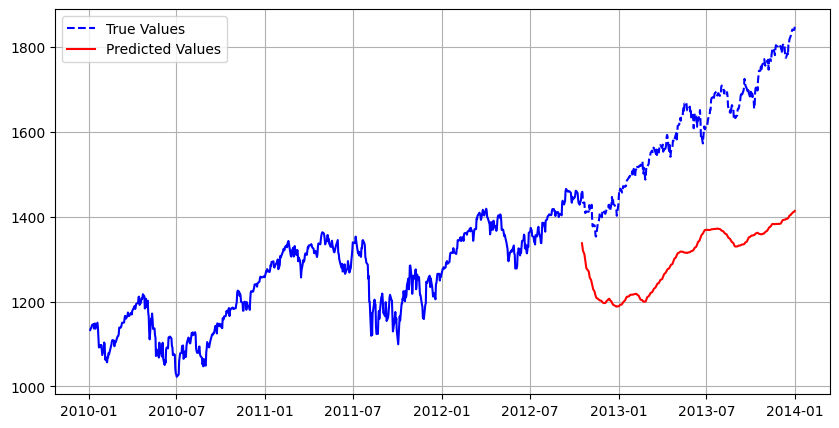

In [46]:
fig = plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(special_data[:-len(predictions)],
         "b-")
plt.plot(special_data[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(special_data.index[-len(predictions):], predictions,"r-",
         label='Predicted Values')
plt.legend()